In [7]:
import obspy
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.core.stream import Stream

class preprocessing:
    def __init__(self, streamz):
        self.streamz = streamz
        #self.trace_add = [] 
        #self.trace_z = trace_z
        #self.trace_n = trace_n
        #self.trace_e = trace_e
    
    def split(self):
        """
        Select each traces in stream then plot them
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.select.html
        documentation for details
        """
        channel_info = self.streamz[0].stats['channel']
        network = self.streamz[0].stats['network']
        station = self.streamz[0].stats['station']

        self.trace_z = self.streamz.select(channel = "*Z")[0]
        self.trace_n = self.streamz.select(channel = "*N")[0] 
        self.trace_e = self.streamz.select(channel = "*E")[0]
        
        #fungsi resampling
    def resamplez(self):
        """
        Resample each traces in stream.
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.resample.html
        documentation for details.
        
        b_rsm = before resample
        a_rsm = after resample
        """
        b_rsm = self.traces
        for i in range(len(b_rsm)):
            a_rsm  = b_rsm[i].resample(int(input("Input Number of Samples: ")))
            b_rsm += a_rsm
            return a_rsm
        else:
            pass
        
    def autotrim(self):
        """
        b_att = before autotrim
        a_att = after autotrim
        """
        b_att = self.traces
        for i in range(len(b_att)):
            self.start = []
            self.end = []
            for i in b_att:
                b_att += int(b_att[i])
                stt = UTCDateTime(b_att[i].stats.starttime)
                edt = UTCDateTime(b_att[i].stats.endtime)
                awal = stt.sort(reverse = True)
                akhir = edt.sort(reverse = False)
                self.start.append(awal)
                self.end.append(akhir)
                #awal = b_att.sort(UTCDateTime('starttime', reverse = True))
                #akhir = b_att.sort(UTCDateTime('endtime', reverse = False))
                starttime = self.start[0]
                endtime = self.end[0]
                a_att = b_att.slice(starttime, endtime)
                b_att += a_att
            return a_att
        
    def cek_input(self):
        """
        Perform checks on inputs.
        Specifically:
        1. Ensure all components have equal `dt`, if not resample.
        2. Ensure all components have same `nsamples`, if not trimm.
            
            ckin = cek input
        """
        ckin = self.traces
        if ckin[0].stats.delta != ckin[1].stats.delta != ckin[2].stats.delta:
            for i in ckin:
                res = ckin[i].resamplez()
                ckin += res
                return ckin
            msg = "All components must have equal `dt`, you must resample them"
            raise ValueError(msg) 
        else:
            pass
        
        # for i in dicti:
        if ckin[0].stats.npts != ckin[1].stats.npts != ckin[2].stats.npts:
            for i in ckin:
                trimz = ckin[i].autotrim()
                ckin += trimz
                return ckin
            msg = f"All components are different length, you must trim them"
            raise ValueError(msg)
        else:
            pass
        
    def detrendz(self):
        """
        Detrend each traces in stream.
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.detrend.html
        documentation for details.
        
        b_dtn = before detrend
        a_dtn = adter detrend
        """
        self.streamz = self.streamz.detrend('linear')
    
    def tpr(self):
        """
        Taper each traces in stream
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.taper.html
        documentation for details
        
        b_tpr = before taper
        a_tpr = after taper
        """
        self.streamz = self.streamz.taper(max_percentage=0.05, type='cosine')
        
    def filterz(self):
        """
        Filter each traces in stream
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html
        documentation for details
        
        b_ftr = before filter
        a_ftr = after filter
        """
        self.streamz = self.streamz.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
        
    def plot_ts(self):
        self.streamz.plot()

In [10]:
from obspy import read
file_path = 'UT.STN11.A2_C50.miniseed'
st = read(file_path)
e = preprocessing(st)
#e.cek_input()
e.split()

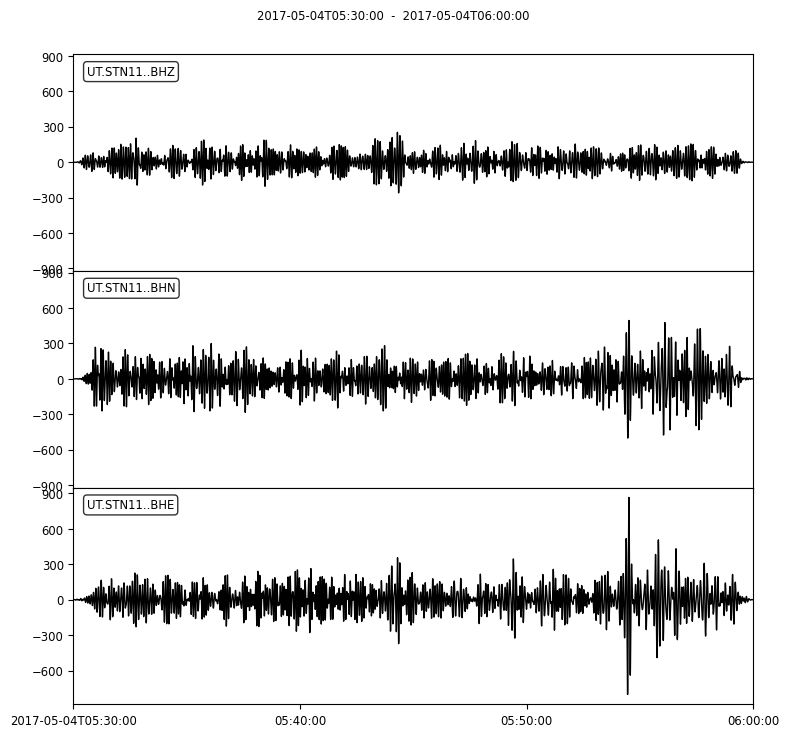

In [11]:
e.detrendz()
e.tpr()
e.filterz()
#print(e)
e.plot_ts()